# Time series

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy import signal
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf, grangercausalitytests

from pathlib import Path

import os, sys
sys.path.insert(0, os.path.abspath('../src'))

from plots import *
from utils import *
from sird import *

In [2]:
data_path = "../data"

In [3]:
DataDownloader(data_path).download_all_csv()

In [4]:
covidpro_df, dpc_regioni_df, dpc_province_df, pop_prov_df, prov_list_df = load_data(data_path)

In [5]:
# Estimate the forecastability

def ApEn(U, m, r):
    """Compute Aproximate entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    N = len(U)
    return abs(_phi(m+1) - _phi(m))

def SampEn(U, m, r):
    """Compute Sample entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))

## Exploration TS: infected Firenze

In [6]:
province = "Firenze"
compart = "New_cases"
date = 'Date'

In [7]:
tmp_df = covidpro_df[covidpro_df.Province == province]

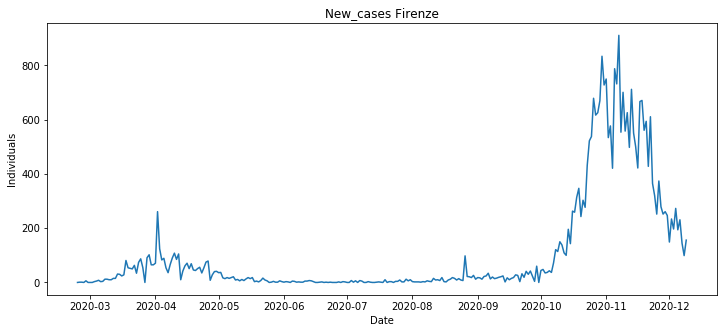

In [8]:
# Visualize TS

plt.figure(figsize=(12,5))
plt.plot(tmp_df[date], tmp_df[compart])
plt.gca().set(title=compart + " " + province, xlabel='Date', ylabel='Individuals')
plt.show()

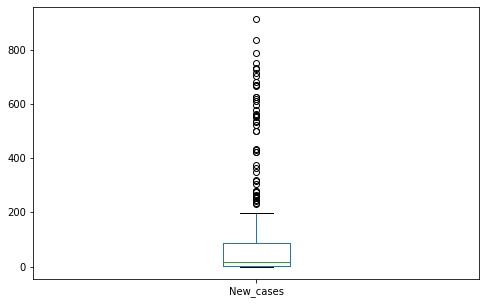

In [9]:
plt.figure(figsize=(8,5))
tmp_df.boxplot(column=[compart], grid=False)
plt.show()

In [10]:
tmp_df = tmp_df.set_index(date)

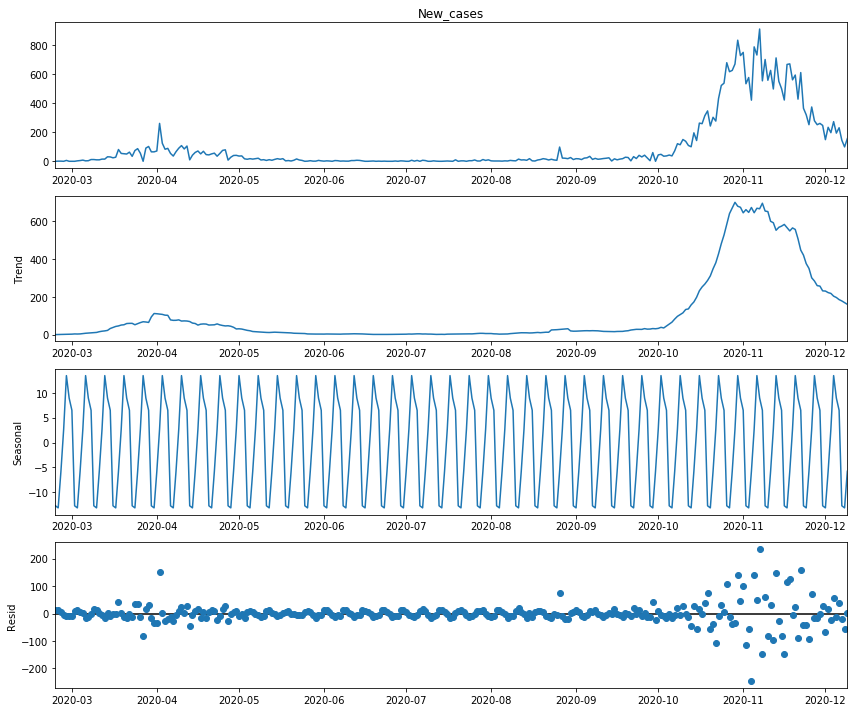

In [11]:
# Decompose TS

# Additive Decomposition
result_add = seasonal_decompose(tmp_df[compart], model='additive', extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (12,10)})
result_add.plot()
plt.show()

In [12]:
# Test for stationarity and trend stationarity

"""
ADF test: null hypothesis is the time series
possesses a unit root and is non-stationary
"""
result = adfuller(tmp_df[compart].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

"""
KPSS test: opposite of ADF
"""
result = kpss(tmp_df[compart].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.9758023534900544
p-value: 0.03721678379146367
Critial Values:
   1%, -3.4544435065994437
Critial Values:
   5%, -2.8721468827772774
Critial Values:
   10%, -2.572422013959188

KPSS Statistic: 0.758027
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739
/home/nick/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(warn_msg.format(direction="smaller"), InterpolationWarning)


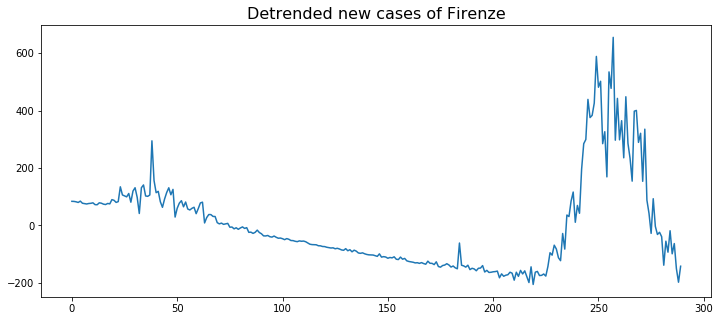

In [13]:
# Detrend by subtracting best leastsq fit
detrended = signal.detrend(tmp_df[compart].values)

plt.figure(figsize=(12,5))
plt.plot(detrended)
plt.title('Detrended new cases of ' + province, fontsize=16)
plt.show()

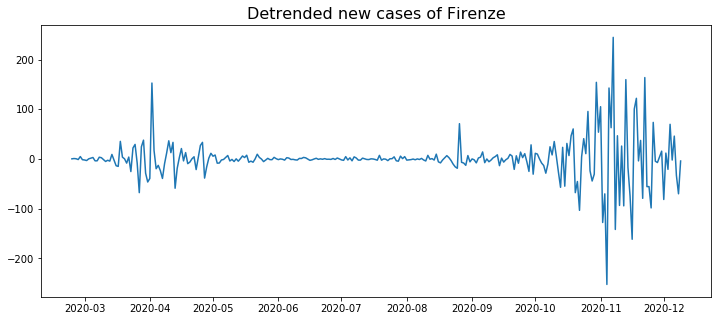

In [14]:
# Detrend by subtracting trend comp

#result_add = seasonal_decompose(tmp_df[compart], model='additive', extrapolate_trend='freq')
detrended = tmp_df[compart].values - result_add.trend

plt.figure(figsize=(12,5))
plt.plot(detrended)
plt.title('Detrended new cases of ' + province, fontsize=16)
plt.show()

In [15]:
# Detrending
y_detrend =  (tmp_df[compart] - tmp_df[compart].rolling(window=30).mean())/tmp_df[compart].rolling(window=30).std()

# then test stationarity
# and ADF

# we could also combine detrending and shifting
y_12lag_detrend =  y_detrend - y_detrend.shift(12)

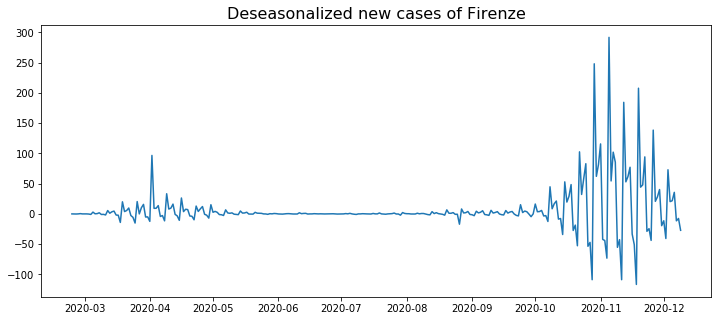

In [16]:
# Deseasonalize by subtracting trend

#result_add = seasonal_decompose(tmp_df[compart], model='additive', extrapolate_trend='freq')

deseasonalized = tmp_df[compart].values / result_add.seasonal

plt.figure(figsize=(12,5))
plt.plot(deseasonalized)
plt.title('Deseasonalized new cases of ' + province, fontsize=16)
plt.plot()
plt.show()

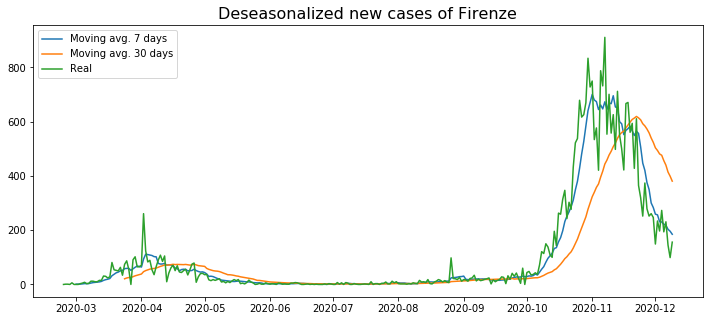

In [17]:
# Deseasonalize by taking mov. avg. with length = seasonal window

plt.figure(figsize=(12,5))
plt.plot(tmp_df.index, tmp_df[compart].rolling(window=7).mean(), label='Moving avg. 7 days')
plt.plot(tmp_df.index, tmp_df[compart].rolling(window=30).mean(), label='Moving avg. 30 days')
plt.plot(tmp_df.index, tmp_df[compart].values, label='Real')
plt.title('Deseasonalized new cases of ' + province, fontsize=16)
plt.legend()
plt.show()

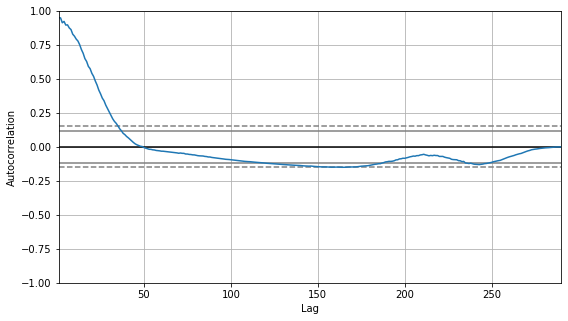

In [18]:
# Seasonality test
plt.rcParams.update({'figure.figsize': (9,5)})
autocorrelation_plot(tmp_df[compart].tolist())
plt.show()

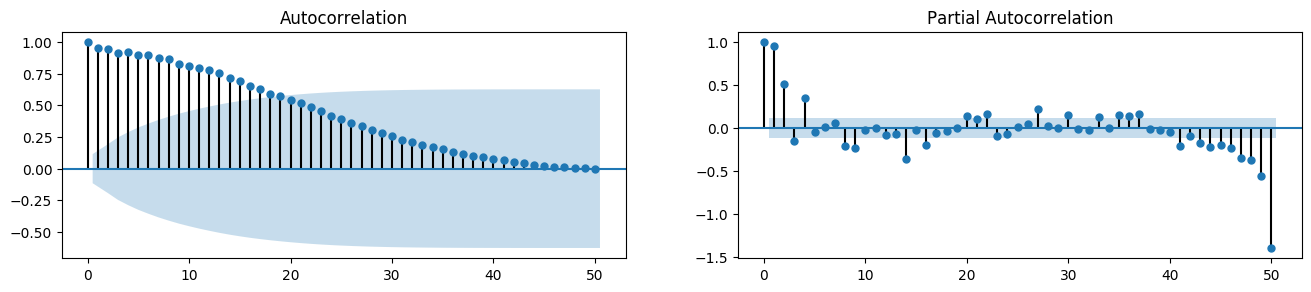

In [19]:
# Autocorrelation and partial autocorrelation

# Calculate ACF and PACF upto 50 lags
acf_50 = acf(tmp_df[compart], nlags=50)
pacf_50 = pacf(tmp_df[compart], nlags=50)

fig, axes = plt.subplots(1, 2, figsize=(16,3), dpi=100)
plot_acf(tmp_df[compart].tolist(), lags=50, ax=axes[0])
plot_pacf(tmp_df[compart].tolist(), lags=50, ax=axes[1])
plt.show()

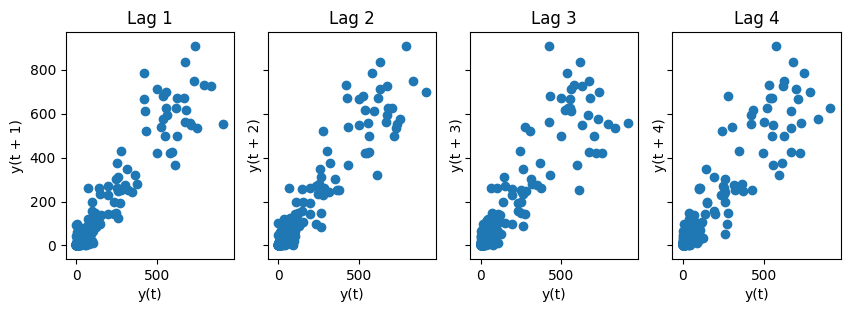

In [20]:
"""
Lag plots:

If points get wide and scattered with increasing lag, 
this means lesser correlation
"""

fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(tmp_df[compart], lag=i+1, ax=ax)
    ax.set_title('Lag ' + str(i+1))

plt.show()

In [21]:
# Estimate forecastability
print("SampEn:", SampEn(tmp_df[compart].values, m=2, r=0.2*np.std(tmp_df[compart].values)))
print("ApproxEn:", ApEn(tmp_df[compart].values, m=2, r=0.2*np.std(tmp_df[compart].values))) 

SampEn: 0.08969363102750517
ApproxEn: 0.24777649675081914


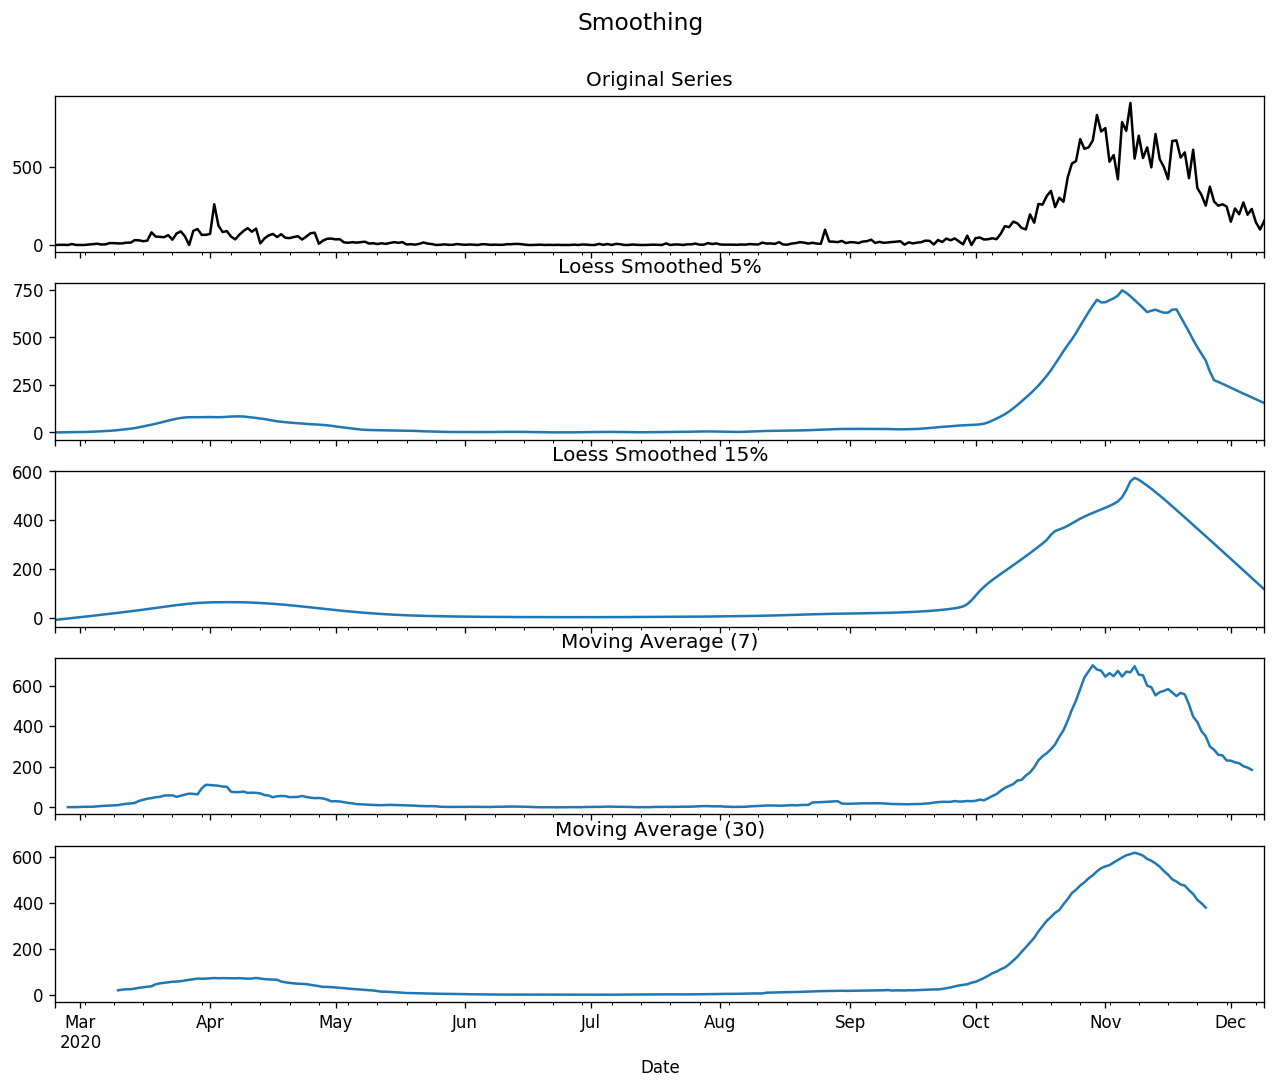

In [22]:
# Smoothing

# 1. Moving Average
df_ma1 = tmp_df[compart].rolling(7, center=True, closed='both').mean()
df_ma2 = tmp_df[compart].rolling(30, center=True, closed='both').mean()

# 2. Loess Smoothing (5% and 15%)
df_loess_5 = pd.DataFrame(lowess(tmp_df[compart], np.arange(len(tmp_df[compart])), frac=0.05)[:, 1], index=tmp_df.index, columns=[compart])
df_loess_15 = pd.DataFrame(lowess(tmp_df[compart], np.arange(len(tmp_df[compart])), frac=0.15)[:, 1], index=tmp_df.index, columns=[compart])

# Plot
fig, axes = plt.subplots(5,1, figsize=(13, 10), sharex=True, dpi=120)
tmp_df[compart].plot(ax=axes[0], color='k', title='Original Series')
df_loess_5[compart].plot(ax=axes[1], title='Loess Smoothed 5%')
df_loess_15[compart].plot(ax=axes[2], title='Loess Smoothed 15%')
df_ma1.plot(ax=axes[3], title='Moving Average (7)')
df_ma2.plot(ax=axes[4], title='Moving Average (30)')
fig.suptitle('Smoothing', y=0.95, fontsize=14)
plt.show()

In [23]:
"""
Granger causality tests:

Infected - Month
Infected - Deaths
"""

tmp_df = covidpro_df[covidpro_df.Province == province]

tmp_df['month'] = tmp_df[date].dt.month
gc_res = grangercausalitytests(tmp_df[[compart, 'month']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0126  , p=0.0837  , df_denom=286, df_num=1
ssr based chi2 test:   chi2=3.0442  , p=0.0810  , df=1
likelihood ratio test: chi2=3.0282  , p=0.0818  , df=1
parameter F test:         F=3.0126  , p=0.0837  , df_denom=286, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3696  , p=0.6914  , df_denom=283, df_num=2
ssr based chi2 test:   chi2=0.7522  , p=0.6865  , df=2
likelihood ratio test: chi2=0.7512  , p=0.6869  , df=2
parameter F test:         F=0.3696  , p=0.6914  , df_denom=283, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6856  , p=0.5615  , df_denom=280, df_num=3
ssr based chi2 test:   chi2=2.1082  , p=0.5502  , df=3
likelihood ratio test: chi2=2.1005  , p=0.5518  , df=3
parameter F test:         F=0.6856  , p=0.5615  , df_denom=280, df_num=3


In [24]:
gc_res = grangercausalitytests(tmp_df[[compart, 'Deaths']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7995  , p=0.3720  , df_denom=286, df_num=1
ssr based chi2 test:   chi2=0.8079  , p=0.3688  , df=1
likelihood ratio test: chi2=0.8067  , p=0.3691  , df=1
parameter F test:         F=0.7995  , p=0.3720  , df_denom=286, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5788  , p=0.0776  , df_denom=283, df_num=2
ssr based chi2 test:   chi2=5.2488  , p=0.0725  , df=2
likelihood ratio test: chi2=5.2015  , p=0.0742  , df=2
parameter F test:         F=2.5788  , p=0.0776  , df_denom=283, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2330  , p=0.2980  , df_denom=280, df_num=3
ssr based chi2 test:   chi2=3.7915  , p=0.2849  , df=3
likelihood ratio test: chi2=3.7666  , p=0.2878  , df=3
parameter F test:         F=1.2330  , p=0.2980  , df_denom=280, df_num=3


## Exploration TS: deaths Firenze

In [25]:
province = "Firenze"
compart = "Deaths"
date = 'Date'

In [26]:
tmp_df = covidpro_df[covidpro_df.Province == province]

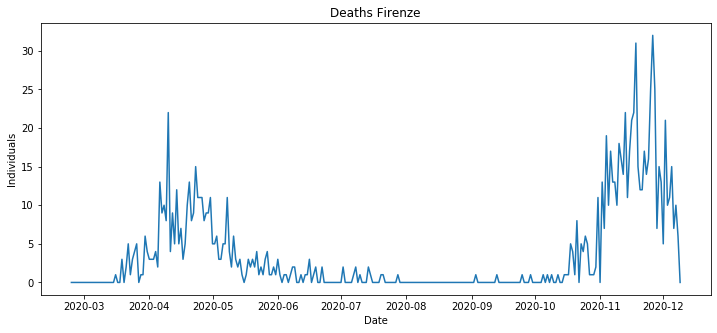

In [27]:
# Visualize TS

plt.figure(figsize=(12,5))
plt.plot(tmp_df[date], tmp_df[compart])
plt.gca().set(title=compart + " " + province, xlabel='Date', ylabel='Individuals')
plt.show()

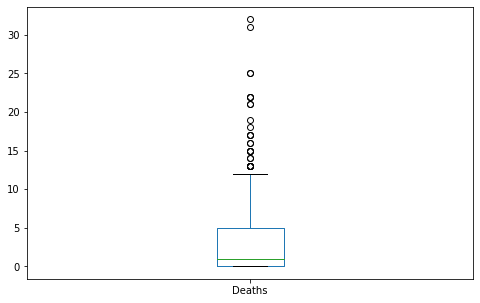

In [28]:
plt.figure(figsize=(8,5))
tmp_df.boxplot(column=[compart], grid=False)
plt.show()

In [29]:
tmp_df = tmp_df.set_index(date)

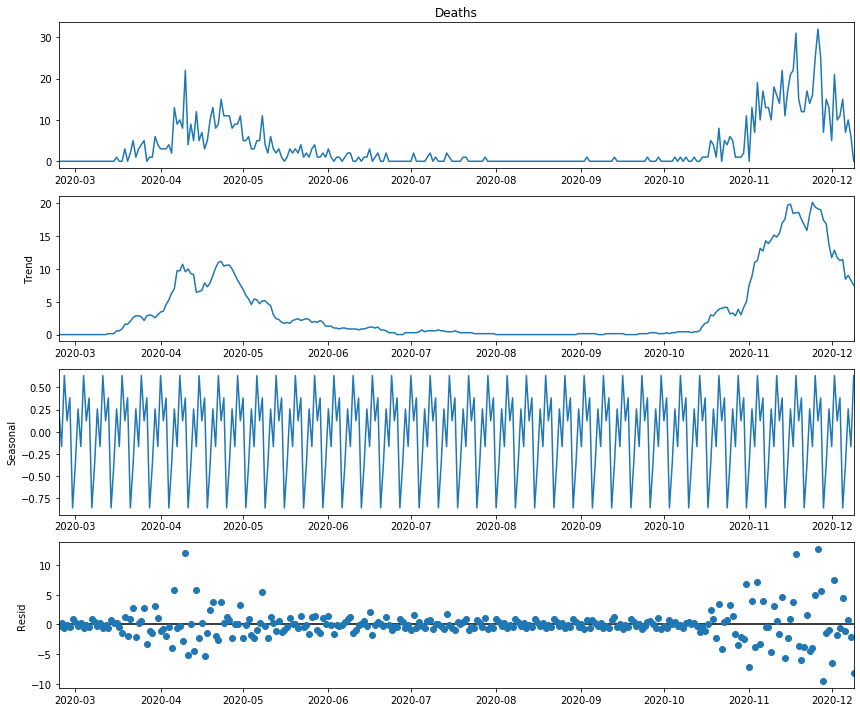

In [30]:
# Decompose TS

# Additive Decomposition
result_add = seasonal_decompose(tmp_df[compart], model='additive', extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (12,10)})
result_add.plot()
plt.show()

In [31]:
# Test for stationarity and trend stationarity

"""
ADF test: null hypothesis is the time series
possesses a unit root and is non-stationary
"""
result = adfuller(tmp_df[compart].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

"""
KPSS test: opposite of ADF
"""
result = kpss(tmp_df[compart].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.7519413702967155
p-value: 0.06547326647232678
Critial Values:
   1%, -3.45453261164607
Critial Values:
   5%, -2.8721859575020017
Critial Values:
   10%, -2.572442854861866

KPSS Statistic: 0.365743
p-value: 0.091921
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


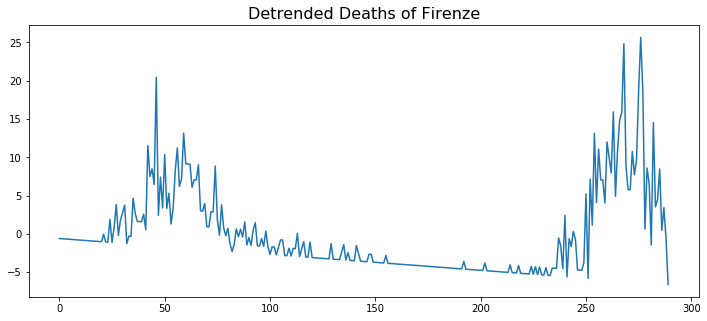

In [32]:
# Detrend by subtracting best leastsq fit
detrended = signal.detrend(tmp_df[compart].values)

plt.figure(figsize=(12,5))
plt.plot(detrended)
plt.title('Detrended ' + compart + ' of ' + province, fontsize=16)
plt.show()

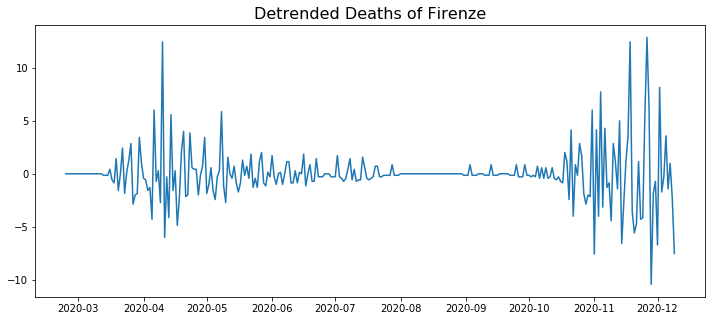

In [33]:
# Detrend by subtracting trend comp

#result_add = seasonal_decompose(tmp_df[compart], model='additive', extrapolate_trend='freq')
detrended = tmp_df[compart].values - result_add.trend

plt.figure(figsize=(12,5))
plt.plot(detrended)
plt.title('Detrended ' + compart + ' of ' + province, fontsize=16)
plt.show()

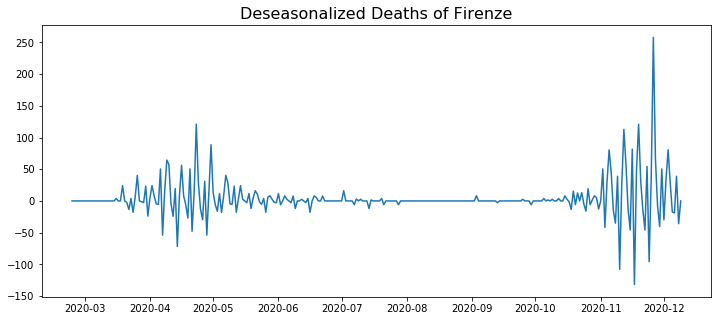

In [34]:
# Deseasonalize by subtracting trend

#result_add = seasonal_decompose(tmp_df[compart], model='additive', extrapolate_trend='freq')

deseasonalized = tmp_df[compart].values / result_add.seasonal

plt.figure(figsize=(12,5))
plt.plot(deseasonalized)
plt.title('Deseasonalized ' + compart + ' of ' + province, fontsize=16)
plt.plot()
plt.show()

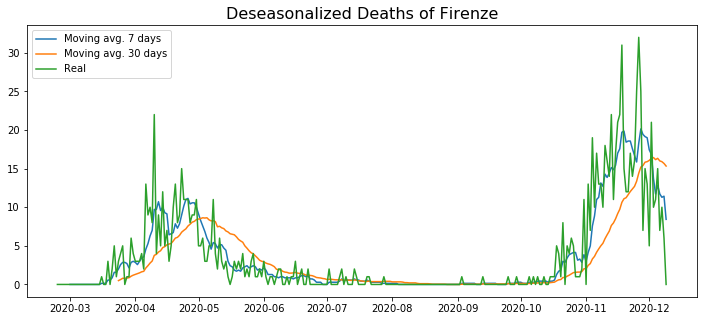

In [35]:
# Deseasonalize by taking mov. avg. with length = seasonal window

plt.figure(figsize=(12,5))
plt.plot(tmp_df.index, tmp_df[compart].rolling(window=7).mean(), label='Moving avg. 7 days')
plt.plot(tmp_df.index, tmp_df[compart].rolling(window=30).mean(), label='Moving avg. 30 days')
plt.plot(tmp_df.index, tmp_df[compart].values, label='Real')
plt.title('Deseasonalized ' + compart + ' of ' + province, fontsize=16)
plt.legend()
plt.show()

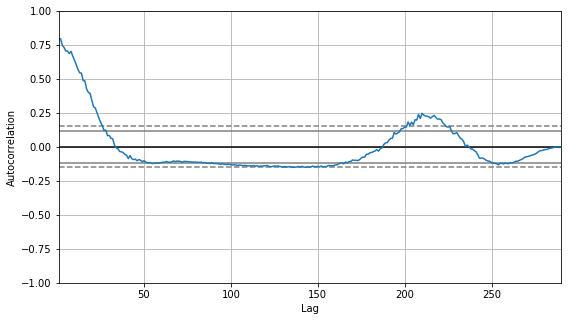

In [36]:
# Seasonality test

plt.rcParams.update({'figure.figsize': (9,5)})
autocorrelation_plot(tmp_df[compart].tolist())
plt.show()

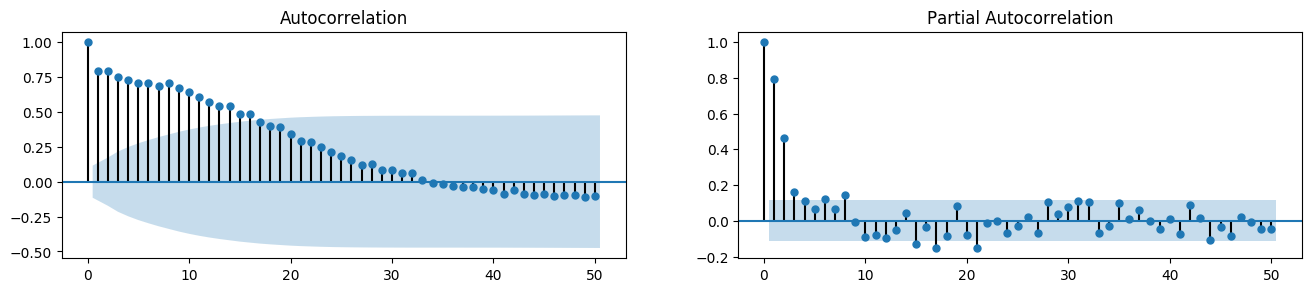

In [37]:
# Autocorrelation and partial autocorrelation

# Calculate ACF and PACF upto 50 lags
acf_50 = acf(tmp_df[compart], nlags=50)
pacf_50 = pacf(tmp_df[compart], nlags=50)

fig, axes = plt.subplots(1, 2, figsize=(16,3), dpi=100)
plot_acf(tmp_df[compart].tolist(), lags=50, ax=axes[0])
plot_pacf(tmp_df[compart].tolist(), lags=50, ax=axes[1])
plt.show()

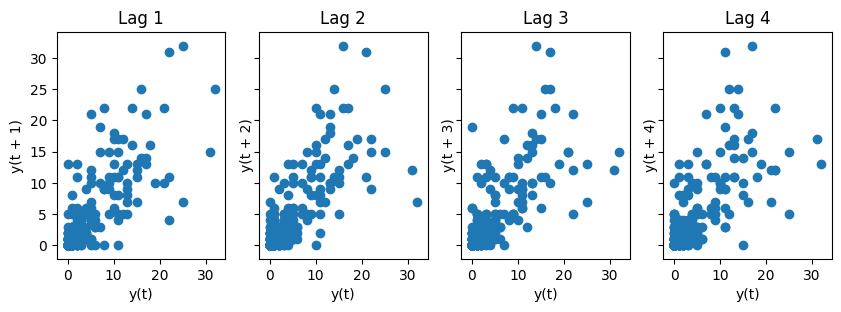

In [38]:
"""
Lag plots:

If points get wide and scattered with increasing lag, 
this means lesser correlation
"""

fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(tmp_df[compart], lag=i+1, ax=ax)
    ax.set_title('Lag ' + str(i+1))

plt.show()

In [39]:
# Estimate forecastability
print("SampEn:", SampEn(tmp_df[compart].values, m=2, r=0.2*np.std(tmp_df[compart].values)))
print("ApproxEn:", ApEn(tmp_df[compart].values, m=2, r=0.2*np.std(tmp_df[compart].values))) 

SampEn: 0.18732204802912877
ApproxEn: 0.47577134095104867


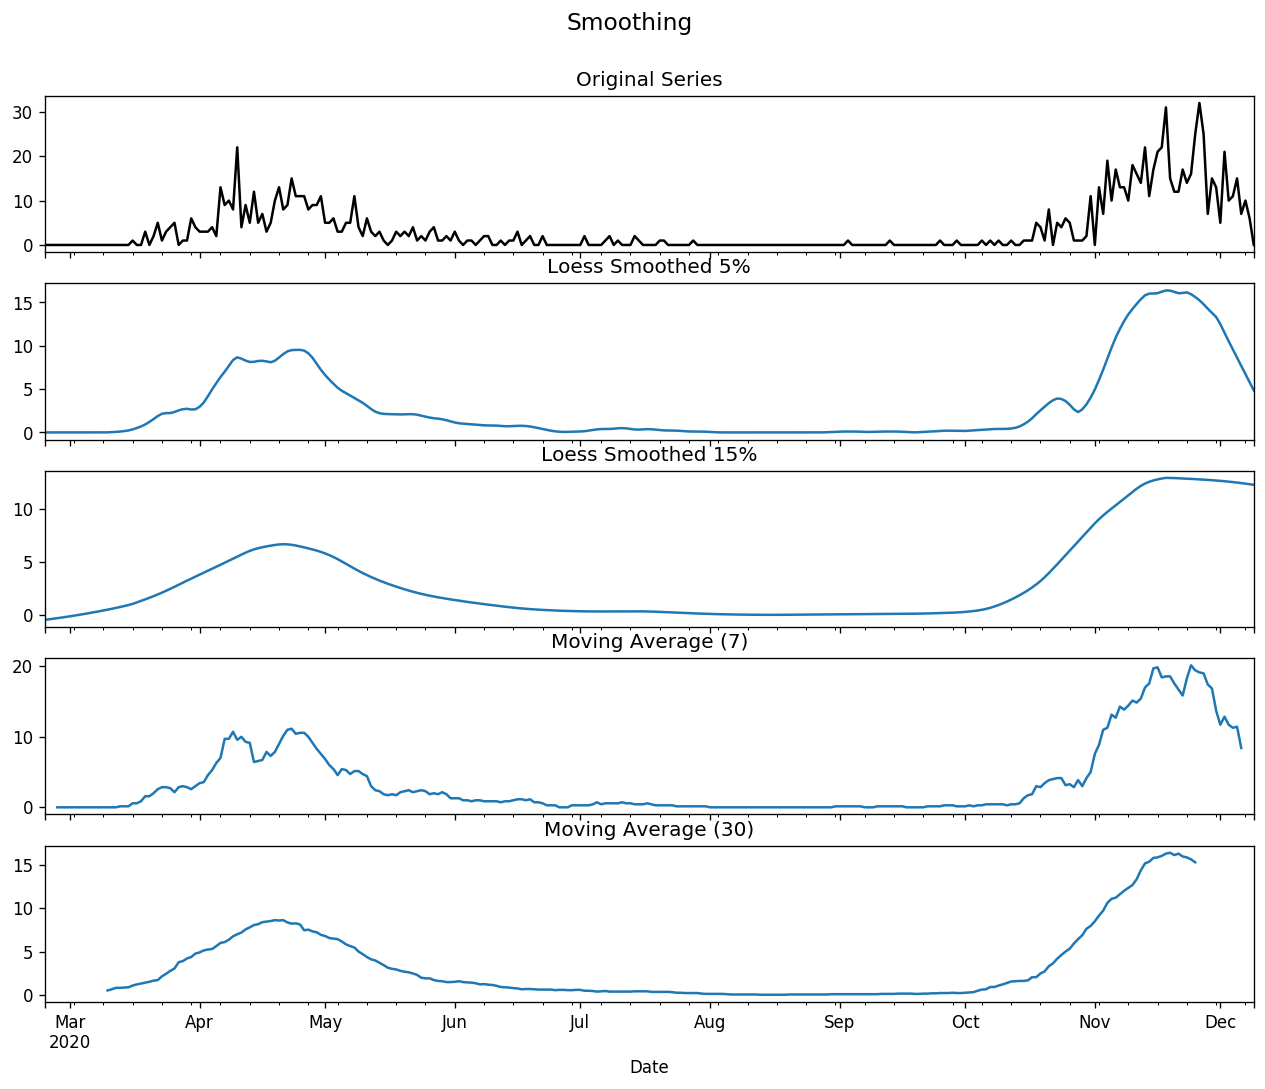

In [40]:
# Smoothing

# 1. Moving Average
df_ma1 = tmp_df[compart].rolling(7, center=True, closed='both').mean()
df_ma2 = tmp_df[compart].rolling(30, center=True, closed='both').mean()

# 2. Loess Smoothing (5% and 15%)
df_loess_5 = pd.DataFrame(lowess(tmp_df[compart], np.arange(len(tmp_df[compart])), frac=0.05)[:, 1], index=tmp_df.index, columns=[compart])
df_loess_15 = pd.DataFrame(lowess(tmp_df[compart], np.arange(len(tmp_df[compart])), frac=0.15)[:, 1], index=tmp_df.index, columns=[compart])

# Plot
fig, axes = plt.subplots(5,1, figsize=(13, 10), sharex=True, dpi=120)
tmp_df[compart].plot(ax=axes[0], color='k', title='Original Series')
df_loess_5[compart].plot(ax=axes[1], title='Loess Smoothed 5%')
df_loess_15[compart].plot(ax=axes[2], title='Loess Smoothed 15%')
df_ma1.plot(ax=axes[3], title='Moving Average (7)')
df_ma2.plot(ax=axes[4], title='Moving Average (30)')
fig.suptitle('Smoothing', y=0.95, fontsize=14)
plt.show()

In [41]:
"""
Granger causality tests:

Deaths - Month
Deaths - Infected
"""


tmp_df = covidpro_df[covidpro_df.Province == province]

tmp_df['month'] = tmp_df[date].dt.month
gc_res = grangercausalitytests(tmp_df[[compart, 'month']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8913  , p=0.0901  , df_denom=286, df_num=1
ssr based chi2 test:   chi2=2.9216  , p=0.0874  , df=1
likelihood ratio test: chi2=2.9069  , p=0.0882  , df=1
parameter F test:         F=2.8913  , p=0.0901  , df_denom=286, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6630  , p=0.1914  , df_denom=283, df_num=2
ssr based chi2 test:   chi2=3.3847  , p=0.1841  , df=2
likelihood ratio test: chi2=3.3649  , p=0.1859  , df=2
parameter F test:         F=1.6630  , p=0.1914  , df_denom=283, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0205  , p=0.3840  , df_denom=280, df_num=3
ssr based chi2 test:   chi2=3.1379  , p=0.3708  , df=3
likelihood ratio test: chi2=3.1209  , p=0.3734  , df=3
parameter F test:         F=1.0205  , p=0.3840  , df_denom=280, df_num=3


In [42]:
gc_res = grangercausalitytests(tmp_df[[compart, 'New_cases']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=24.1965 , p=0.0000  , df_denom=286, df_num=1
ssr based chi2 test:   chi2=24.4503 , p=0.0000  , df=1
likelihood ratio test: chi2=23.4709 , p=0.0000  , df=1
parameter F test:         F=24.1965 , p=0.0000  , df_denom=286, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.3631  , p=0.0020  , df_denom=283, df_num=2
ssr based chi2 test:   chi2=12.9510 , p=0.0015  , df=2
likelihood ratio test: chi2=12.6683 , p=0.0018  , df=2
parameter F test:         F=6.3631  , p=0.0020  , df_denom=283, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=10.9660 , p=0.0000  , df_denom=280, df_num=3
ssr based chi2 test:   chi2=33.7204 , p=0.0000  , df=3
likelihood ratio test: chi2=31.8821 , p=0.0000  , df=3
parameter F test:         F=10.9660 , p=0.0000  , df_denom=280, df_num=3


## Exploration TS: Infected Piemonte

In [43]:
province = "Piemonte"
compart = "nuovi_positivi"
date = 'data'

In [44]:
tmp_df = dpc_regioni_df[dpc_regioni_df.denominazione_regione == province]

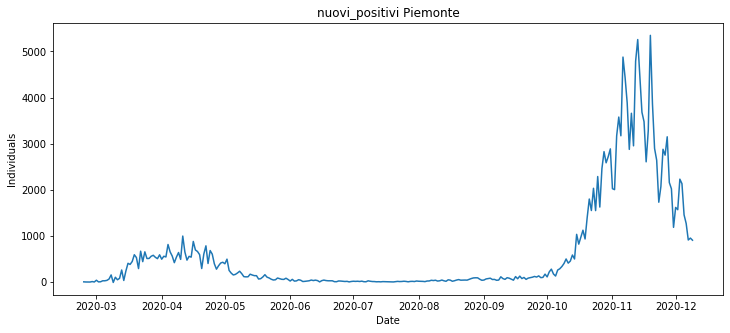

In [45]:
# Visualize TS

plt.figure(figsize=(12,5))
plt.plot(tmp_df[date], tmp_df[compart])
plt.gca().set(title=compart + " " + province, xlabel='Date', ylabel='Individuals')
plt.show()

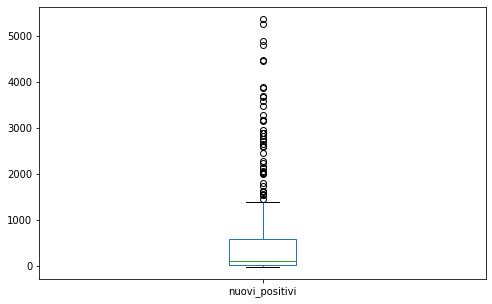

In [46]:
plt.figure(figsize=(8,5))
tmp_df.boxplot(column=[compart], grid=False)
plt.show()

In [47]:
tmp_df = tmp_df.set_index(date)

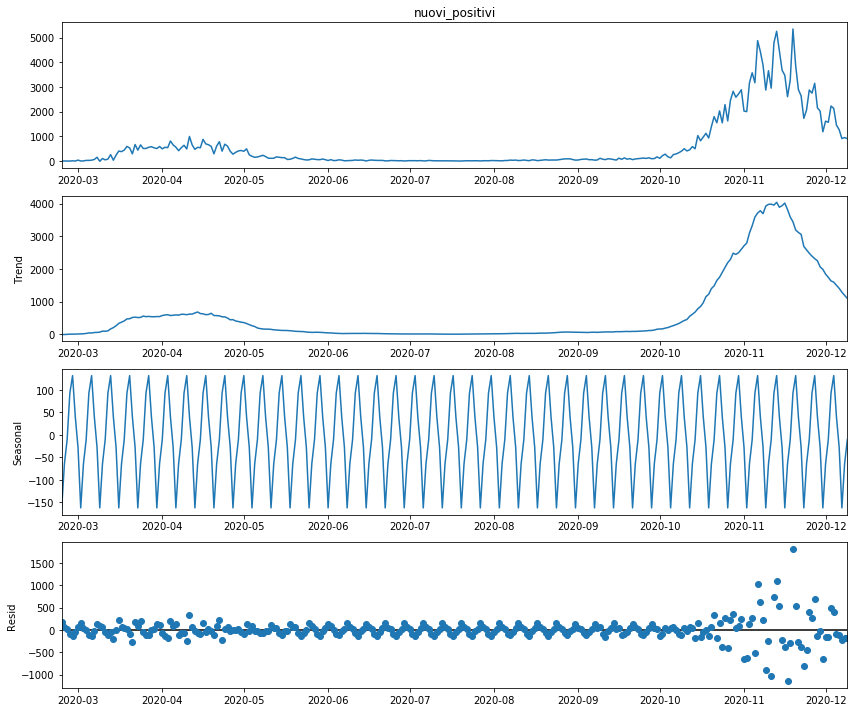

In [48]:
# Decompose TS

# Additive Decomposition
result_add = seasonal_decompose(tmp_df[compart], model='additive', extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (12,10)})
result_add.plot()
plt.show()

In [49]:
# Test for stationarity and trend stationarity

"""
ADF test: null hypothesis is the time series
possesses a unit root and is non-stationary
"""
result = adfuller(tmp_df[compart].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

"""
KPSS test: opposite of ADF
"""
result = kpss(tmp_df[compart].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -3.2542363788724504
p-value: 0.017052220515733407
Critial Values:
   1%, -3.4541800885158525
Critial Values:
   5%, -2.872031361137725
Critial Values:
   10%, -2.5723603999791473

KPSS Statistic: 0.701979
p-value: 0.013366
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


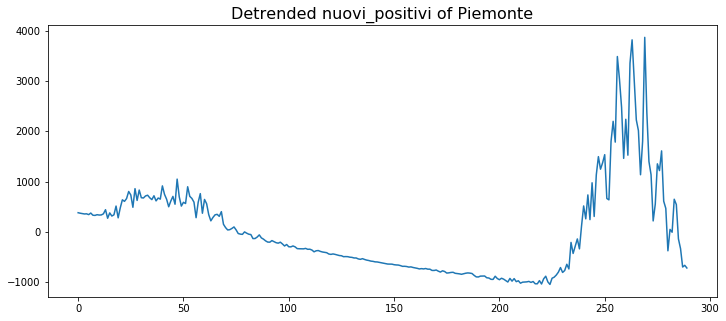

In [50]:
# Detrend by subtracting best leastsq fit
detrended = signal.detrend(tmp_df[compart].values)

plt.figure(figsize=(12,5))
plt.plot(detrended)
plt.title('Detrended ' + compart + ' of ' + province, fontsize=16)
plt.show()

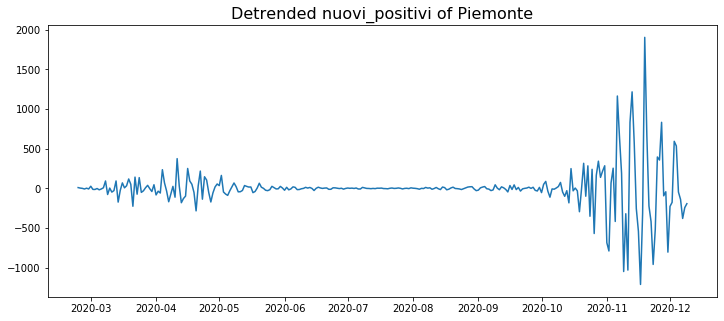

In [51]:
# Detrend by subtracting trend comp

#result_add = seasonal_decompose(tmp_df[compart], model='additive', extrapolate_trend='freq')
detrended = tmp_df[compart].values - result_add.trend

plt.figure(figsize=(12,5))
plt.plot(detrended)
plt.title('Detrended ' + compart + ' of ' + province, fontsize=16)
plt.show()

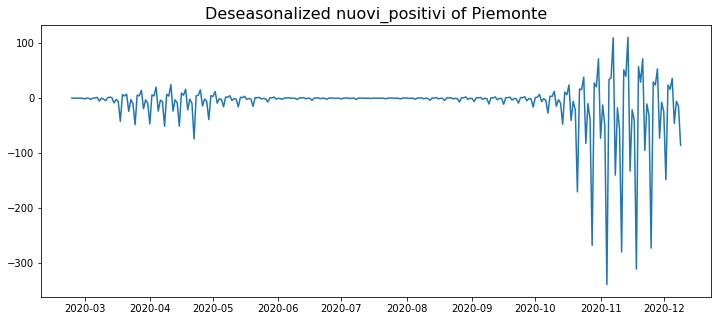

In [52]:
# Deseasonalize by subtracting trend

#result_add = seasonal_decompose(tmp_df[compart], model='additive', extrapolate_trend='freq')

deseasonalized = tmp_df[compart].values / result_add.seasonal

plt.figure(figsize=(12,5))
plt.plot(deseasonalized)
plt.title('Deseasonalized ' + compart + ' of ' + province, fontsize=16)
plt.plot()
plt.show()

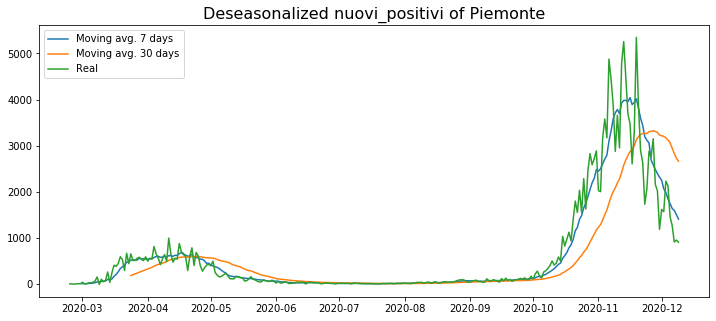

In [53]:
# Deseasonalize by taking mov. avg. with length = seasonal window

plt.figure(figsize=(12,5))
plt.plot(tmp_df.index, tmp_df[compart].rolling(window=7).mean(), label='Moving avg. 7 days')
plt.plot(tmp_df.index, tmp_df[compart].rolling(window=30).mean(), label='Moving avg. 30 days')
plt.plot(tmp_df.index, tmp_df[compart].values, label='Real')
plt.title('Deseasonalized ' + compart + ' of ' + province, fontsize=16)
plt.legend()
plt.show()

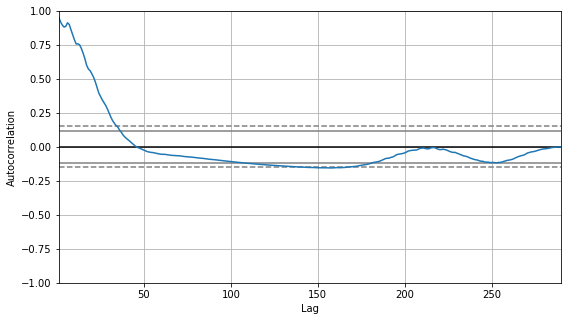

In [54]:
# Seasonality test

plt.rcParams.update({'figure.figsize': (9,5)})
autocorrelation_plot(tmp_df[compart].tolist())
plt.show()

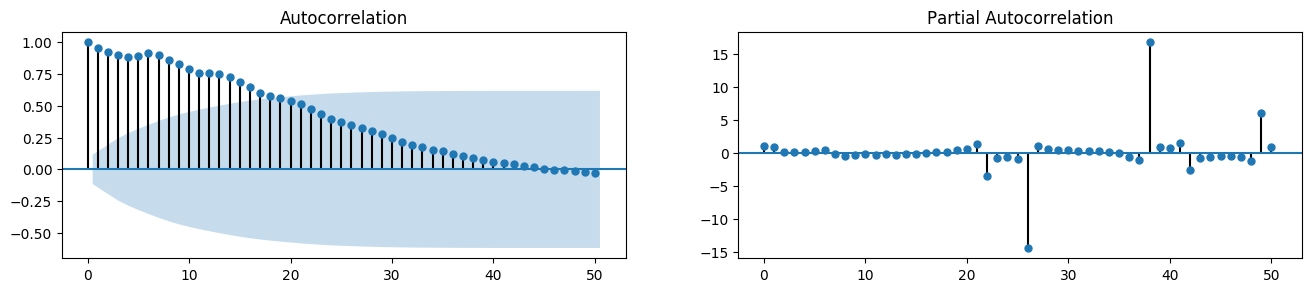

In [55]:
# Autocorrelation and partial autocorrelation

# Calculate ACF and PACF upto 50 lags
acf_50 = acf(tmp_df[compart], nlags=50)
pacf_50 = pacf(tmp_df[compart], nlags=50)

fig, axes = plt.subplots(1, 2, figsize=(16,3), dpi=100)
plot_acf(tmp_df[compart].tolist(), lags=50, ax=axes[0])
plot_pacf(tmp_df[compart].tolist(), lags=50, ax=axes[1])
plt.show()

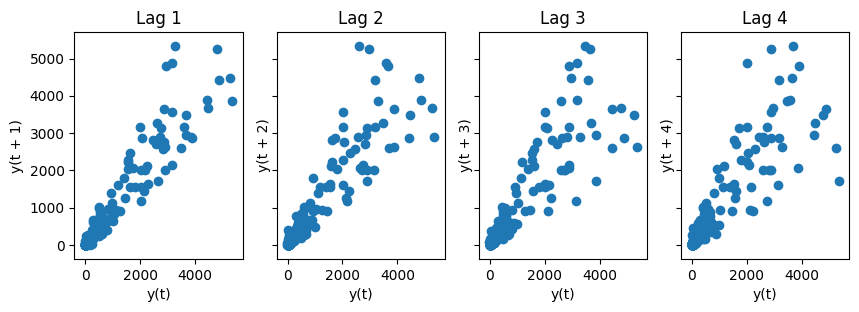

In [56]:
"""
Lag plots:

If points get wide and scattered with increasing lag, 
this means lesser correlation
"""

fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(tmp_df[compart], lag=i+1, ax=ax)
    ax.set_title('Lag ' + str(i+1))

plt.show()

In [57]:
# Estimate forecastability
print("SampEn:", SampEn(tmp_df[compart].values, m=2, r=0.2*np.std(tmp_df[compart].values)))
print("ApproxEn:", ApEn(tmp_df[compart].values, m=2, r=0.2*np.std(tmp_df[compart].values))) 

SampEn: 0.05746845736195552
ApproxEn: 0.22000641707903767


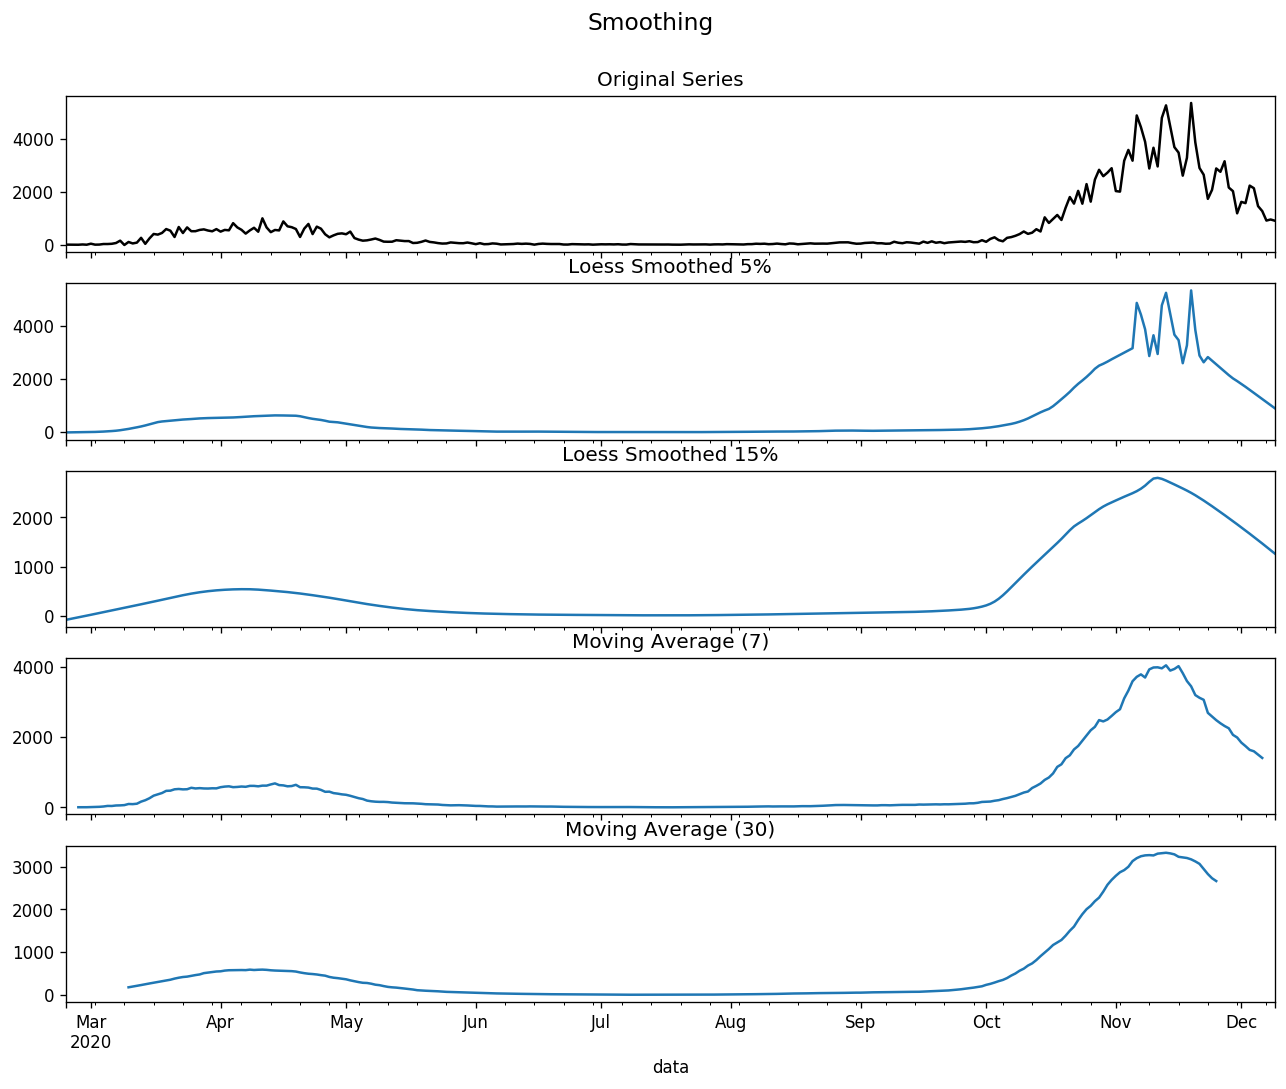

In [58]:
# Smoothing

# 1. Moving Average
df_ma1 = tmp_df[compart].rolling(7, center=True, closed='both').mean()
df_ma2 = tmp_df[compart].rolling(30, center=True, closed='both').mean()

# 2. Loess Smoothing (5% and 15%)
df_loess_5 = pd.DataFrame(lowess(tmp_df[compart], np.arange(len(tmp_df[compart])), frac=0.05)[:, 1], index=tmp_df.index, columns=[compart])
df_loess_15 = pd.DataFrame(lowess(tmp_df[compart], np.arange(len(tmp_df[compart])), frac=0.15)[:, 1], index=tmp_df.index, columns=[compart])

# Plot
fig, axes = plt.subplots(5,1, figsize=(13, 10), sharex=True, dpi=120)
tmp_df[compart].plot(ax=axes[0], color='k', title='Original Series')
df_loess_5[compart].plot(ax=axes[1], title='Loess Smoothed 5%')
df_loess_15[compart].plot(ax=axes[2], title='Loess Smoothed 15%')
df_ma1.plot(ax=axes[3], title='Moving Average (7)')
df_ma2.plot(ax=axes[4], title='Moving Average (30)')
fig.suptitle('Smoothing', y=0.95, fontsize=14)
plt.show()

In [59]:
"""
Granger causality tests:

Deaths - Month
Deaths - Infected
"""


tmp_df = dpc_regioni_df[dpc_regioni_df.denominazione_regione == province]

tmp_df['month'] = tmp_df[date].dt.month
gc_res = grangercausalitytests(tmp_df[[compart, 'month']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7874  , p=0.0961  , df_denom=286, df_num=1
ssr based chi2 test:   chi2=2.8166  , p=0.0933  , df=1
likelihood ratio test: chi2=2.8030  , p=0.0941  , df=1
parameter F test:         F=2.7874  , p=0.0961  , df_denom=286, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0278  , p=0.3591  , df_denom=283, df_num=2
ssr based chi2 test:   chi2=2.0919  , p=0.3513  , df=2
likelihood ratio test: chi2=2.0844  , p=0.3527  , df=2
parameter F test:         F=1.0278  , p=0.3591  , df_denom=283, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2079  , p=0.3072  , df_denom=280, df_num=3
ssr based chi2 test:   chi2=3.7144  , p=0.2940  , df=3
likelihood ratio test: chi2=3.6905  , p=0.2969  , df=3
parameter F test:         F=1.2079  , p=0.3072  , df_denom=280, df_num=3


In [60]:
gc_res = grangercausalitytests(tmp_df[[compart, 'deceduti']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0423  , p=0.8372  , df_denom=286, df_num=1
ssr based chi2 test:   chi2=0.0427  , p=0.8363  , df=1
likelihood ratio test: chi2=0.0427  , p=0.8363  , df=1
parameter F test:         F=0.0423  , p=0.8372  , df_denom=286, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0099  , p=0.9901  , df_denom=283, df_num=2
ssr based chi2 test:   chi2=0.0202  , p=0.9899  , df=2
likelihood ratio test: chi2=0.0202  , p=0.9899  , df=2
parameter F test:         F=0.0099  , p=0.9901  , df_denom=283, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0940  , p=0.9633  , df_denom=280, df_num=3
ssr based chi2 test:   chi2=0.2890  , p=0.9621  , df=3
likelihood ratio test: chi2=0.2888  , p=0.9621  , df=3
parameter F test:         F=0.0940  , p=0.9633  , df_denom=280, df_num=3


## Prediction

In [61]:
province = "Firenze"
compart = "New_cases"
date = 'Date'

tmp_df = covidpro_df[covidpro_df.Province == province]
tmp_df = tmp_df.set_index(date)

In [62]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [63]:
def adv_ma_plot(df, compart, window, plot_intervals=False, scale=1.96, plot_anomalies=False, show_anomalies_label=False, legend_position='upper left'):
    rolling_mean = df[[compart]].rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    #plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    if plot_intervals:
        mae = mean_absolute_error(df[[compart]][window:], rolling_mean[window:])
        deviation = np.std(df[[compart]][window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, "r--", label="Upper Bound / Lower Bound")
        plt.plot(lower_bound, "r--")
        
        if plot_anomalies:
            
            anomalies = pd.DataFrame(index=df[[compart]].index, columns=df[[compart]].columns)
            anomalies[df[[compart]]<lower_bound] = df[[compart]][df[[compart]]<lower_bound]
            anomalies[df[[compart]]>upper_bound] = df[[compart]][df[[compart]]>upper_bound]
            plt.plot(anomalies, "ro", markersize=10)

            if show_anomalies_label:
                ymin, ymax = plt.ylim()
                plt.vlines(anomalies.dropna().index, ymin=ymin, ymax=ymax, linestyles='dashed', colors='grey')
                for x in anomalies.dropna().index:
                    #plt.axvline(x, linestyle='--', c='grey')
                    plt.text(x, ymin + 20, x.strftime('%m-%d'), rotation=90, verticalalignment='center')
        
    plt.plot(df[[compart]][window:], label="Actual values")
    plt.legend(loc=legend_position)
    plt.show()

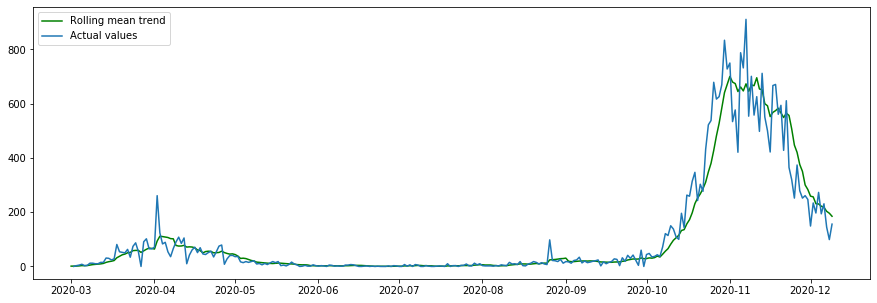

In [64]:
adv_ma_plot(tmp_df, compart, 7)

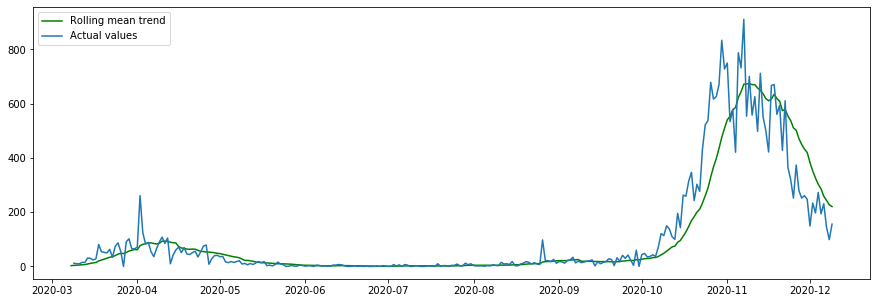

In [65]:
adv_ma_plot(tmp_df, compart, 14)

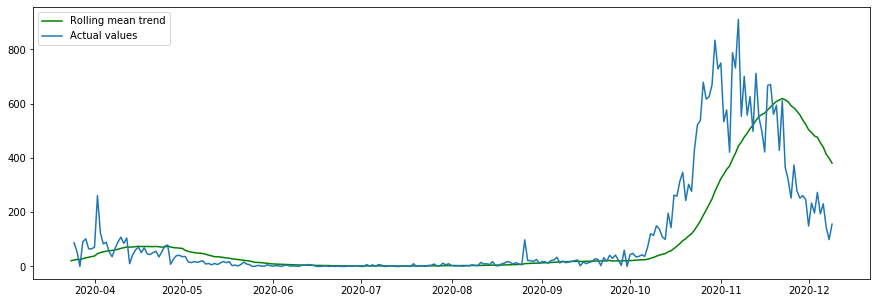

In [66]:
adv_ma_plot(tmp_df, compart, 30)

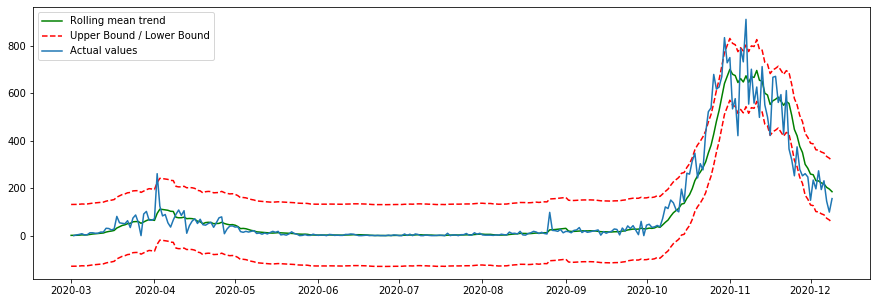

In [67]:
adv_ma_plot(tmp_df, compart, 7, plot_intervals=True)

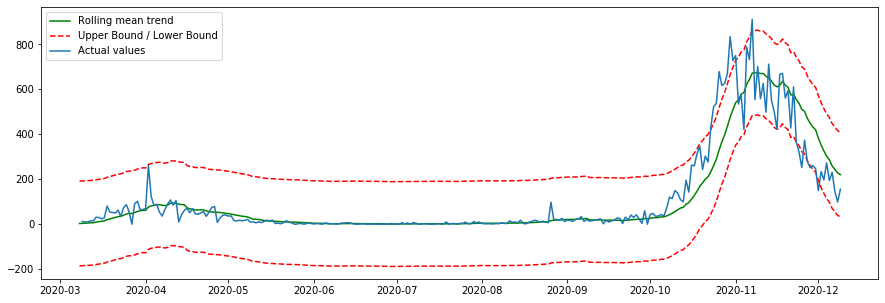

In [68]:
adv_ma_plot(tmp_df, compart, 14, plot_intervals=True)

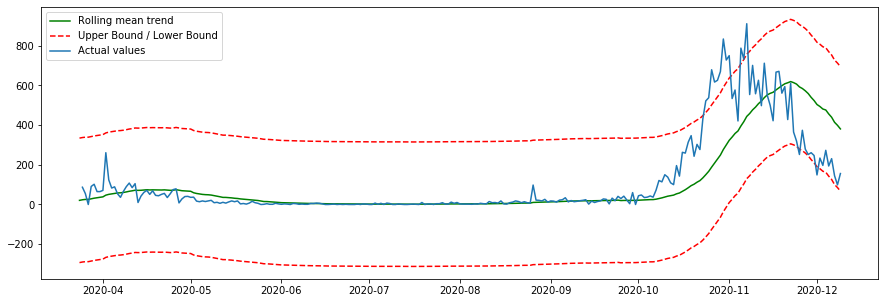

In [69]:
adv_ma_plot(tmp_df, compart, 30, plot_intervals=True)

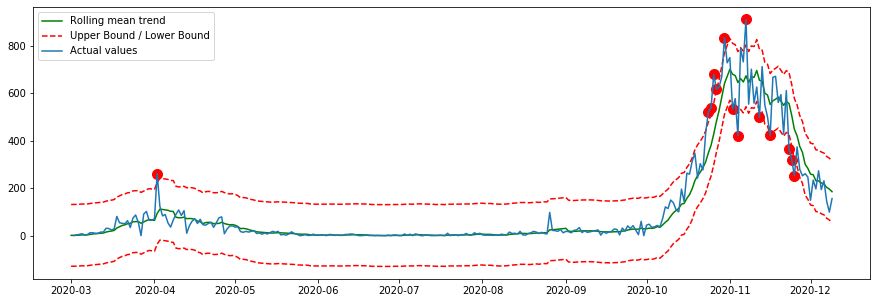

In [70]:
adv_ma_plot(tmp_df, compart, 7, plot_intervals=True, plot_anomalies=True)

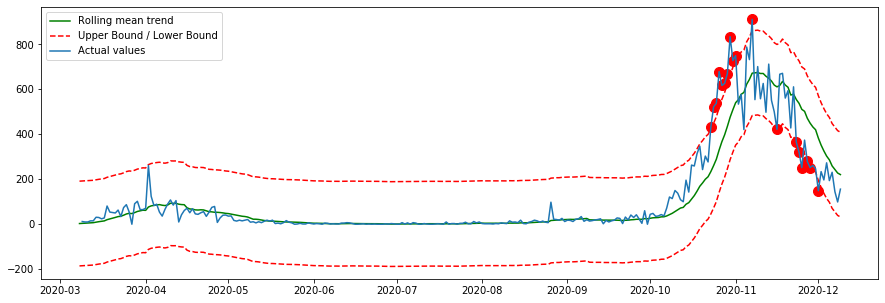

In [71]:
adv_ma_plot(tmp_df, compart, 14, plot_intervals=True, plot_anomalies=True)

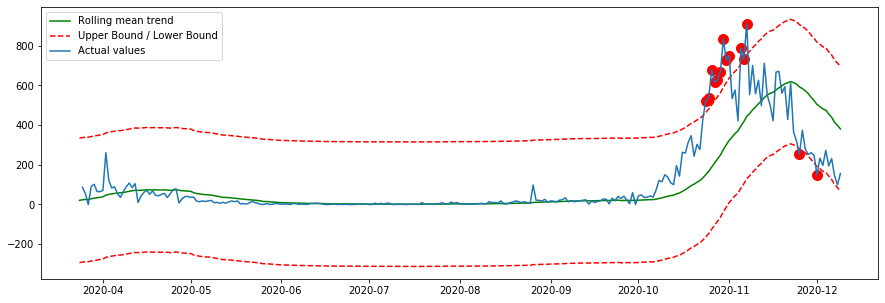

In [72]:
adv_ma_plot(tmp_df, compart, 30, plot_intervals=True, plot_anomalies=True)

In [73]:
province = "Firenze"
compart = "New_cases"
date = 'Date'

tmp_df = covidpro_df[covidpro_df.Province == province].query('20200701 > Date')
tmp_df = tmp_df.set_index(date)

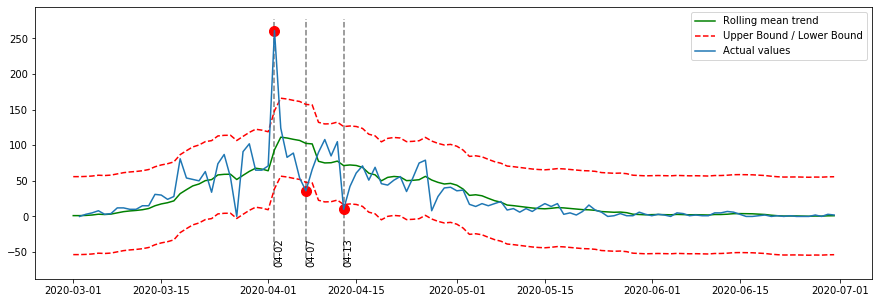

In [74]:
adv_ma_plot(tmp_df, compart, 7, plot_intervals=True, plot_anomalies=True, show_anomalies_label=True, legend_position='upper right')

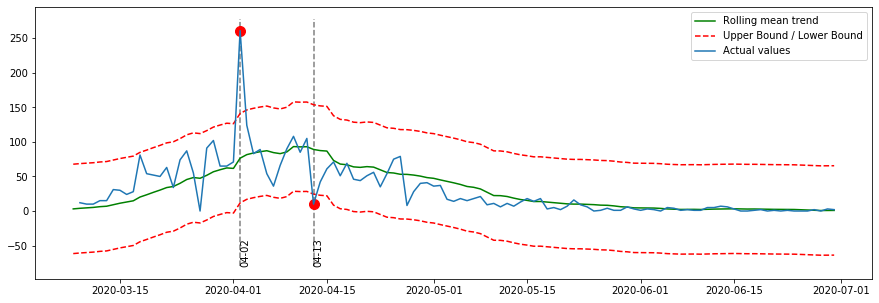

In [75]:
adv_ma_plot(tmp_df, compart, 14, plot_intervals=True, plot_anomalies=True, show_anomalies_label=True, legend_position='upper right')

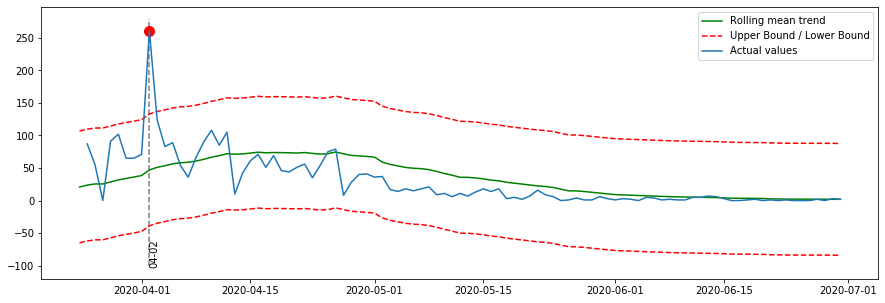

In [76]:
adv_ma_plot(tmp_df, compart, 30, plot_intervals=True, plot_anomalies=True, show_anomalies_label=True, legend_position='upper right')

In [77]:
province = "Firenze"
compart = "New_cases"
date = 'Date'

tmp_df = covidpro_df[covidpro_df.Province == province].query('20201208 > Date > 20200901')
tmp_df = tmp_df.set_index(date)

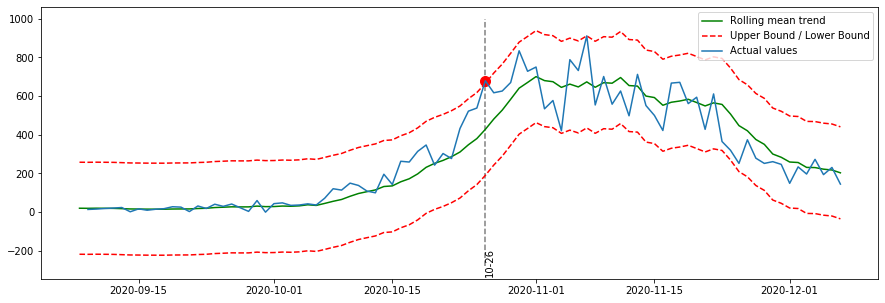

In [78]:
adv_ma_plot(tmp_df, compart, 7, plot_intervals=True, plot_anomalies=True, show_anomalies_label=True, legend_position='upper right')

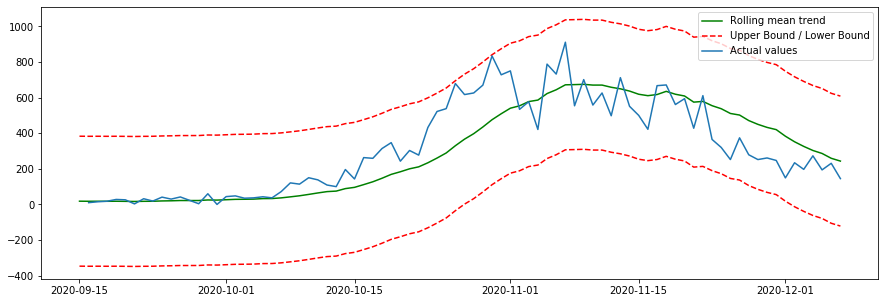

In [79]:
adv_ma_plot(tmp_df, compart, 14, plot_intervals=True, plot_anomalies=True, show_anomalies_label=True, legend_position='upper right')

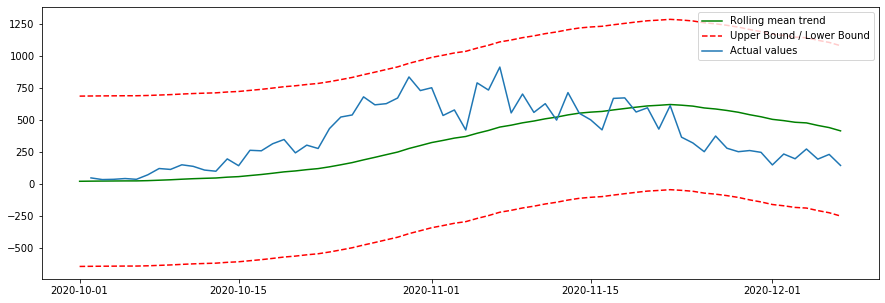

In [80]:
adv_ma_plot(tmp_df, compart, 30, plot_intervals=True, plot_anomalies=True, show_anomalies_label=True, legend_position='upper right')

In [81]:
province = "Firenze"
compart = "New_cases"
date = 'Date'

tmp_df = covidpro_df[covidpro_df.Province == province].query('20200701 > Date')
tmp_df = tmp_df.set_index(date)

In [82]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [83]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    plt.figure(figsize=(15, 7))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.show()

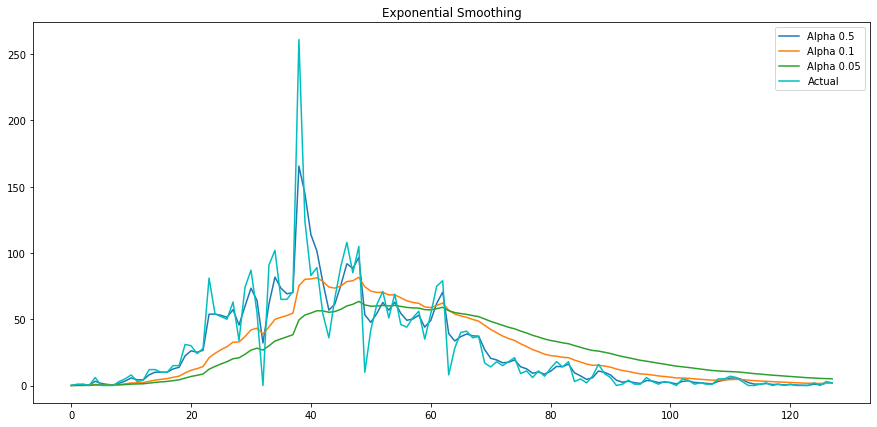

In [87]:
plotExponentialSmoothing(tmp_df[[compart]][compart], alphas=[0.5, 0.1, 0.05])

In [170]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt

train = tmp_df[[compart]].query('20200601 > Date')
test = tmp_df[[compart]].query('20200601 <= Date')

model = ExponentialSmoothing(train[compart].values)
model_fit = model.fit()

yhat = model_fit.predict(start=0,end=len(test)-1)

In [178]:
print("AIC:", model_fit.aic)
print("AICC:", model_fit.aicc)
print("BIC:", model_fit.bic)
print("k:", model_fit.k)
print("SSE:", model_fit.sse)
print("\n",model_fit.mle_retvals)

AIC: 656.5547714231992
AICC: 656.9848789500809
BIC: 661.7247063805404
k: 2
SSE: 76396.3069816789

      fun: 76396.3069816789
     jac: array([-0.17871094,  0.00195312])
 message: 'Optimization terminated successfully.'
    nfev: 28
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.28646561, 1.23140556])


In [177]:
model_fit.params_formatted

name     param  optimized
smoothing_level  alpha  0.286466       True
initial_level      l.0  1.231406       True

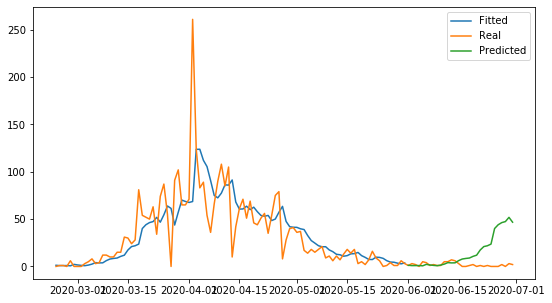

In [171]:
plt.plot(train.index, model_fit.fittedvalues, label='Fitted')
plt.plot(tmp_df.index, tmp_df[compart].values, label='Real')
plt.plot(test.index, yhat, label='Predicted')
plt.legend()
plt.show()

In [179]:
train = tmp_df[[compart]].query('20200601 > Date')
test = tmp_df[[compart]].query('20200601 <= Date')

model = Holt(train[compart].values)
model_fit = model.fit()

yhat = model_fit.predict(start=0,end=len(test)-1)

/home/nick/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [180]:
print("AIC:", model_fit.aic)
print("AICC:", model_fit.aicc)
print("BIC:", model_fit.bic)
print("k:", model_fit.k)
print("SSE:", model_fit.sse)
print("\n",model_fit.mle_retvals)

AIC: 660.5547727337721
AICC: 661.477849656849
BIC: 670.8946426484544
k: 4
SSE: 76396.30800334137

      fun: 76396.30800334137
     jac: array([2.58486328e+01, 2.18742344e+04, 9.17968750e-02, 3.18359375e-01])
 message: 'Positive directional derivative for linesearch'
    nfev: 93
     nit: 15
    njev: 11
  status: 8
 success: False
       x: array([2.86536609e-01, 8.83362568e-06, 1.16795792e+00, 2.45453135e-02])


In [181]:
model_fit.params_formatted

name     param  optimized
smoothing_level  alpha  0.286537       True
smoothing_trend   beta  0.000009       True
initial_level      l.0  1.167958       True
initial_trend      b.0  0.024545       True

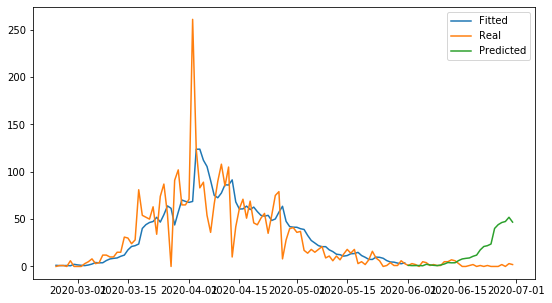

In [182]:
plt.plot(train.index, model_fit.fittedvalues, label='Fitted')
plt.plot(tmp_df.index, tmp_df[compart].values, label='Real')
plt.plot(test.index, yhat, label='Predicted')
plt.legend()
plt.show()